<a href="https://colab.research.google.com/github/jyanqa/Narative-Economy/blob/main/Daily_Data_Macro_2021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np

## 1 Data

In [ ]:
url = 'https://drive.google.com/uc?id=' +  '1VXuxMfSYwZY80SlB7e1HfPshvwo72l2T'
df = pd.read_csv(url, sep = '|')

### Subset

In [ ]:
# speech in 2021
d21 = df[(df['date'] > '2018-01-01') & (df['date'] < '2021-5-31')]
#drop empty row
d21 = d21.dropna(how ='any')
#dataframe | remain only two colums
d21 = d21[['date','contents']]

#### Merge text groupby day

In [ ]:

from datetime import date 
d21['date'] = pd.to_datetime(d21['date']) #convert columns date to datetime

#groupby speech in the same date
d21['date'] = pd.to_datetime(d21['date'])
d21['speeches'] = d21.groupby(['date'])['contents'].transform(lambda x: ','.join(x)) 
df21 = d21[['date','speeches']].drop_duplicates()

#---
df21.head(1) #df21.shape[0]

,date,speeches
0,2021-05-27,SPEECH Societal responsibility and central...


#### Split into sentences

In [ ]:
a = df21
cols_name = ['yymm', 'sent']
df_sent = pd.DataFrame(columns=cols_name)
for i in range(a.shape[0]):
    yymm = a.iloc[i][0]
    text = a.iloc[i][1]
    sent_temp = text.split('.')
    df_temp = pd.DataFrame(columns=cols_name)
    for t in sent_temp:
        arr = [yymm,t] #value of a ro
        df_length = len(df_sent) #
        df_sent.loc[df_length] = arr 
df_sent.head(2)

,yymm,sent
0,2021-05-27,SPEECH Societal responsibility and central...
1,2021-05-27,"New Paradigm Workshop”, organised by the Foru..."


#### Assign topic to a sentence.

## 2 ECB Communication

We measure the ECB's communication by two features: Topic and Tone. That is, we determine first the economic topic of the speeches. After that, we measures how they are talking about it (tone). In this paper, we make use of Latent Dirichlet Allocation (LDA) to know when they are talking about economic topic and a balance measure based on dictionary methods, or word counting, to measure tone. By combining these two approaches allows us to measure topic-level tone which helps to deal, somewhat, with the weakness of dictionary methods. That is, rather than just measure words associated with expansion, we can measure expansion words associated with GDP growth rather than risk premia.

### Step 1: Assign topics tp a sentence 

In [ ]:
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import string
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [ ]:
import string
import re
import nltk

from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
  
ps = PorterStemmer()

In [ ]:
otherstop =  ['-', '%', 'g','bank', 'ecb','euro', 'also','speech','financial','-;','le','p','r','j','f','c','one',
             'e','op','-','_','left','(chart', 'likely', 'could','l','n','(question', '()','del','di', 'u','w',
                'h', 'b','k', 'q', 'v','co','listen',  'nevertheless', 'truly', 'enable', 'aml', 'somewhat', 'get', 
              'add', 'partly', 'http', 'brings', 'ed', 'known', 'became','missing',  'likelihood', 'der', 'fed', 'und', 
              'notion', 'sepa','offering', 'follows', 'offered', 'tell', 'really', 'anniversary', 'determine',
              'learning', 'ask', 'hearing', 'bringing', 'unique', 'represent', 'seriously', 'analytical', 'ex', 
              'desired', 'meaningful', 'delivered', 'generate', 'multi', 'expressed', 'analyse', 'eur', 'round', 
              'unlike', 'relating', 'accounting', 'happened', 'bit', 'wish', 'applying', 'hour', 'weigh', 'managing', 
              'von', 'resolve', 'likewise', 'culture', 'compare', 'usually', 'favour', 'otc', 'nairu', 'portugal', 
              'coin', 'live', 'vi', 'pronounced', 'lehman', 'branch', 'underpin', 'maintained', 'ab', 'youth', 'human', 
              'page', 'indicate', 'capture', 'official', 'represented', 'greek', 'stop', 'worked', 'repos', 'focusing', 
              'dialogue', 'discussing', 'reported', 'concluded', 'cepr', 'prior', 'fcis', 'italy','spain','germany',
              'netherland','x','netherlands','italian','die','feel','fifth','elswhere','person','slightly', 'omt', 
              'traditionally','french', 'entirely','assessed','orderly','sharply','wall','latter','woman','st','talk',
              'fairly','forget','bearing','preventing','altavilla','exception','collective', 'recorded', 'steadily',
              'tail','supportive','spanish','workshop','domain','acted','nonetheless','focused','noted','opening',
              'attractive','sample','frequently','eye','suggested','coefficient','ois','learn','gone','recieved',
              'luxembourg','slovakia','involve','obtain','contact','correct','wind','washington','posed','subsequent',
              'check','comment','solely','received', 'chapter','huge','exceptional','obvious', 'versus', 'fast',
              'naturally','entitled','prove','embedded','corresponding','berlin','committed',
              'careful','material','lose','agree','explanation','da','rapidly','continent','greatly',
              'chicago','background','explaining','involving','entered','arising', 'versus','comply',
              'extremely', 'intra', 'neither', 'york', 'japan', 'soon', 'professional', 'none', 'pdf',
              'borne', 'unlikely', 'gained', 'perhaps', 'tomorrow', 'came', 'lie', 'easily', 'ncio', 'met', 'concerned', 
              'seem', 'en', 'decide', 'intended', 'speaking', 'excluding', 'meaning', 'gave', 'prepared', 'refers',
              'wrong', 'begin', 'everyone', 'implied', 'presented', 'refer']
stop= stopwords.words('english')
stop.extend(list(string.punctuation))
stop.extend(otherstop)
lemma=WordNetLemmatizer()
def clean(docx):
    doc = re.sub("[^a-zA-Z]",  # Search for all non-letters
                          " ",          # Replace all non-letters with spaces
                          str(docx))
    doc1 = re.sub(r'\d+', '', doc)
    stop_free=" ".join([i for i in doc1.lower().split() if i not in stop])
    normalized=" ".join(lemma.lemmatize(word) for word in stop_free.split())
    #normalized1 =" ".join(ps.stem(word) for word in normalized.split())
    return normalized
####
##
text_complete = df_sent['sent'].values.tolist()
doc_clean=[clean(text).split() for text in text_complete]

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

SOME_FIXED_SEED = 42
np.random.seed(SOME_FIXED_SEED)
cv=CountVectorizer(min_df=2,max_df=50,#ngram_range=(1,2),
                   token_pattern=None,
                   tokenizer=lambda doc:doc,preprocessor=lambda doc:doc, 
                   stop_words = frozenset(stop))
#'''INPUT HERE'''
cv_features=cv.fit_transform(doc_clean) 
vocabulary=np.array(cv.get_feature_names())

In [ ]:
'''Using sklearn.decomposition LDA with 15 topics'''
from sklearn.decomposition import LatentDirichletAllocation
TOTAL_TOPICS = 15
lda_model=LatentDirichletAllocation(n_components=TOTAL_TOPICS,
                                    max_iter=10,max_doc_update_iter=10,
                                    learning_method='online',batch_size=128,
                                    learning_offset=50.,random_state=42,n_jobs = -1)

'''Using the transformer 'fit_transform'''
document_topics=lda_model.fit_transform(cv_features)

''' Extraqcting the most important 10 terms for each topic'''
topic_terms=lda_model.components_
top_terms=15 # number of 'top terms'
topic_key_terms_idxs=np.argsort(-np.absolute(topic_terms), axis=1)[:,:top_terms]

'''INPUT vocabulary'''
topic_keyterms=vocabulary[topic_key_terms_idxs]
topics=[', '.join(topic) for topic in topic_keyterms]
pd.set_option('display.max_colwidth',None)
topics_df=pd.DataFrame(topics,columns=['Term per Topic'], index=['Topic'+str(t) for t in range(1,TOTAL_TOPICS+1)])
topics_df



,Term per Topic
Topic1,"legislative, buy, resort, wholesale, leaning, weight, risen, lender, permanent, resulted, highlighted, understood, determining, modern, interface"
Topic2,"difficulty, triggered, integrity, standardised, successfully, equal, aftermath, fsb, dealing, equivalent, mitigating, described, tangible, accepted, hole"
Topic3,"tariff, shadow, yves, virtual, meant, concrete, prudent, vc, partner, skill, exit, outflow, reliable, genuine, otherwise"
Topic4,"diversification, contributes, incident, anticipated, simulation, emerged, strategic, complexity, utilisation, narrow, warrant, rose, heightened, weather, patience"
Topic5,"balanced, ec, aligned, store, surrounding, diffusion, characterised, indicated, break, tends, prevented, precisely, fragmented, brief, taylor"
Topic6,"continuing, fear, anchored, revolution, actor, drive, redemption, raised, trough, organisation, seek, planning, reversal, separate, resolved"
Topic7,"converge, moderation, bear, signalling, accept, boom, outright, creates, encouraging, safeguarding, regional, turned, amid, occasion, anticipate"
Topic8,"bubble, harmonisation, statute, contained, ground, fluctuation, argument, box, bund, democracy, belief, proper, phenomenon, prepare, applies"
Topic9,"surprise, application, counterparty, floor, deutsche, pick, thinking, delay, peak, conditional, caput, automation, recognition, track, geopolitical"
Topic10,"sensitivity, ssm, mortgage, albeit, stood, costly, anchoring, commerce, complementary, spirit, adopt, coordinated, backdrop, lecture, passed"


#### WordCloud

In [ ]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [ ]:
''' Extraqcting the most important 150 terms for each topic'''
topic_terms=lda_model.components_
top_terms=150 # number of 'top terms'
topic_key_terms_idxs=np.argsort(-np.absolute(topic_terms), axis=1)[:,:top_terms]

'''INPUT vocabulary'''
topic_keyterms=vocabulary[topic_key_terms_idxs]
topics=[', '.join(topic) for topic in topic_keyterms]
#pd.set_option('display.max_colwidth',None)
topics_df=pd.DataFrame(topics,columns=['Term per Topic'], index=['Topic'+str(t) for t in range(1,TOTAL_TOPICS+1)])
topics_df
topics = topics_df.transpose()

In [ ]:
'''from google.colab import files
from io import BytesIO
from PIL import Image

uploaded = files.upload()
im = Image.open(BytesIO(uploaded['25403.png']))
euro = np.array(im)'''

Saving 25403.png to 25403.png


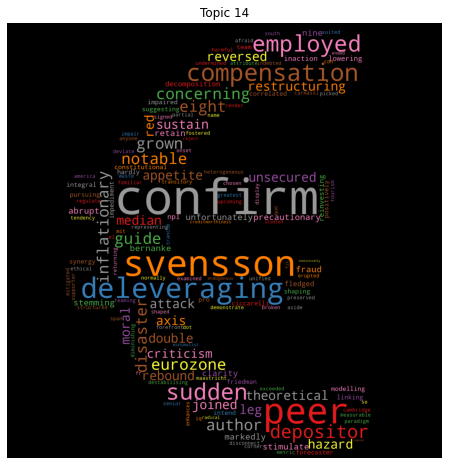

In [ ]:
'''values = ','.join(str(v) for v in topics['Topic14']) 
# A similar function, but using the mask
def generate_better_wordcloud(data, title, mask=None):
    cloud = WordCloud(scale=3,
                      max_words=150,
                      colormap='Set1',
                      mask=mask,
                      background_color='black',
                      stopwords=stop,
                      collocations=True).generate_from_text(data)
    plt.figure(figsize=(8 ,8))
    plt.imshow(cloud)
    plt.axis('off')
    plt.title(title)
    plt.show()
    ''
# Use the function with the rome_corpus and our mask to create word cloud     
generate_better_wordcloud(values, 'Topic 14', mask=euro) '''

### Sentimental Analysis

In [ ]:
doc_topic = lda_model.transform(cv_features)
list_topic = []
for i in range(doc_topic.shape[0]):
    topic_most_pr = doc_topic[i].argmax()
    list_topic.append(topic_most_pr)
df_sent['topic'] = list_topic
df_sent.head(2)

,yymm,sent,topic
0,2021-05-27,"SPEECH Societal responsibility and central bank independence Keynote speech by Isabel Schnabel, Member of the Executive Board of the ECB, at the “VIII",12
1,2021-05-27,"New Paradigm Workshop”, organised by the Forum New Economy Frankfurt am Main, 27 May 2021 Central banking in times of shifting societal concerns The best contribution that central banks can make to economic prosperity is to maintain stable prices: this was the broad consensus among academic scholars and policymakers emerging in the late 1970s when inflation in many advanced economies had surged to double-digit levels, thereby eroding purchasing power and hitting the poorest in society the hardest (Chart 1)",13


In [ ]:
sent1 = df_sent.loc[df_sent['topic']==1]
sent3= df_sent.loc[df_sent['topic']==3]
sent11 = df_sent.loc[df_sent['topic']==7]
sent12 = df_sent.loc[df_sent['topic']==8]
sent13 = df_sent.loc[df_sent['topic']==10]
sent14 = df_sent.loc[df_sent['topic']==14]
sent_all = sent1.append(sent3).append(sent11).append(sent12).append(sent13).append(sent14)
sent_all = sent_all.reset_index(drop = True)
df_ts = sent_all[ sent_all['sent'].astype(str) == sent_all['sent']] #only keep the content whose type data string

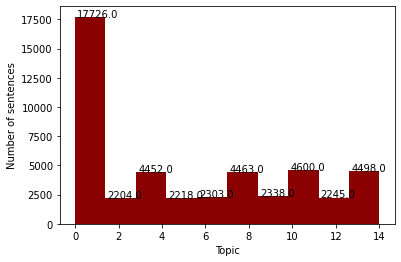

In [ ]:
%matplotlib inline
xvals = np.arange(len(df_sent['topic'].value_counts()))
yvals = list(df_sent['topic'].value_counts())

counts, bins, _ = plt.hist(df_sent['topic'],color = 'darkred')

for n, b in zip(counts, bins):
        plt.gca().text(b + 0.1, n, str(n))
plt.ylabel('Number of sentences')
plt.xlabel('Topic')
plt.show()

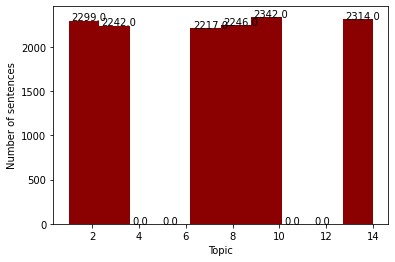

In [ ]:
%matplotlib inline
xvals = np.arange(len(df_ts['topic'].value_counts()))
yvals = list(df_ts['topic'].value_counts())

counts, bins, _ = plt.hist(df_ts['topic'], color = 'darkred')

for n, b in zip(counts, bins):
        plt.gca().text(b + 0.1, n, str(n))
plt.ylabel('Number of sentences')
plt.xlabel('Topic')
plt.show()

In [ ]:
#merge sentences of the same date
df_ts['speeches'] = df_ts.groupby(['yymm'])['sent'].transform(lambda x: ','.join(x)) 
df_ts = df_ts[['yymm','speeches']].drop_duplicates()
df_ts = df_ts.sort_values('yymm')
df_ts.head(1)

yymm                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

In [ ]:
#print(df_topsent.shape) #dataframe from 46k to 13k

In [ ]:
'''df_ts = df_topsent[ df_topsent['sent'].astype(str) == df_topsent['sent']]
print(df_ts.shape)'''

In [ ]:
pip install vaderSentiment

     |████████████████████████████████| 133kB 7.4MB/s 


In [ ]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [ ]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
  
 

In [ ]:
analyzer = SentimentIntensityAnalyzer()
df_ts['neg'] = df_ts['speeches'].apply(lambda x: analyzer.polarity_scores(x)['neg'])
df_ts['neu'] = df_ts['speeches'].apply(lambda x:analyzer.polarity_scores(x)['neu'])
df_ts['pos'] = df_ts['speeches'].apply(lambda x:analyzer.polarity_scores(x)['pos'])
df_ts['compound'] = df_ts['speeches'].apply(lambda x:analyzer.polarity_scores(x)['compound'])
data_ts = df_ts[['yymm','neg','neu','pos','compound']]
data_ts.head(3)

,yymm,neg,neu,pos,compound
2287,2018-01-29,0.079,0.808,0.113,0.9948
2273,2018-01-30,0.062,0.831,0.107,0.9980
2262,2018-01-31,0.072,0.848,0.079,0.7922


In [ ]:
data_ts.head(10).reset_index()[['yymm','neg','neu','pos','compound']]

,yymm,neg,neu,pos,compound
0,2018-01-29,0.079,0.808,0.113,0.9948
1,2018-01-30,0.062,0.831,0.107,0.9980
2,2018-01-31,0.072,0.848,0.079,0.7922
3,2018-02-01,0.041,0.888,0.071,0.8422
4,2018-02-02,0.061,0.827,0.112,0.9426
5,2018-02-05,0.035,0.817,0.147,0.9994
6,2018-02-08,0.070,0.821,0.109,0.9979
7,2018-02-14,0.028,0.873,0.099,0.9946
8,2018-02-15,0.038,0.820,0.142,0.9994
9,2018-02-16,0.055,0.840,0.105,0.9951


### Time Series sentimental by month, groupby compound

In [ ]:
from matplotlib import pyplot as plt
import matplotlib.ticker as plticker

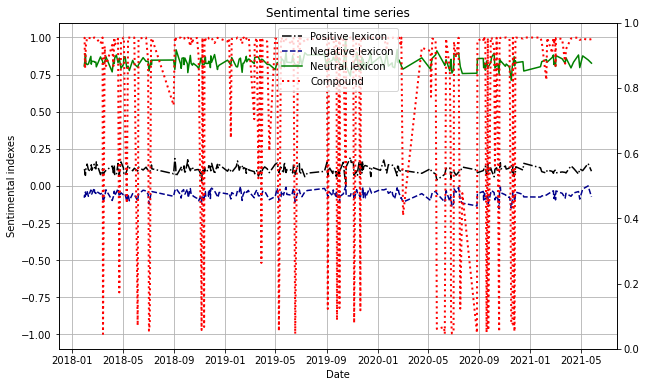

In [ ]:
ts_sent = data_ts
fig, ax = plt.subplots(figsize=(10, 6))
axb = ax.twinx()

# Same as above
ax.set_xlabel('Date')
ax.set_ylabel('Sentimental indexes')
ax.set_title('Sentimental time series')
ax.grid(True)

ax.plot(ts_sent['yymm'], ts_sent['pos'], color='black', label='Positive lexicon ',linestyle = '-.',linewidth=1.5)
ax.plot(ts_sent['yymm'], -ts_sent['neg'], color='darkblue', label='Negative lexicon',linestyle = '--', linewidth=1.5)
ax.plot(ts_sent['yymm'], ts_sent['neu'], color='green', label='Neutral lexicon', linewidth=1.5)
ax.plot(ts_sent['yymm'], ts_sent['compound'] , color='red', label='Compound',linestyle = ':',linewidth = 2.0)

# Merging legend
lines, labels = ax.get_legend_handles_labels()
#lines2, labels2 = axb.get_legend_handles_labels()
axb.legend(lines, labels, loc='upper center');

#plt.savefig('nameofp.png')

### Save data to drive

In [ ]:
from google.colab import files
data_ts.to_csv('ts_sent_day_1.csv') 
files.download("ts_sent_day_1.csv")
%timeit

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Yield Curves

In [ ]:
speeches_ts = pd.read_csv('ts_sent_day_1.csv', sep = ',')
speeches_ts = speeches_ts.rename(columns = {'yymm':'date'})
speeches_ts = speeches_ts[['date','neg','neu','pos','compound']]
speeches_ts = speeches_ts.sort_values('date', ascending=True)
speeches_ts['date'] = pd.to_datetime(speeches_ts['date'])
speeches_ts

,date,neg,neu,pos,compound
0,2018-01-29,0.079,0.808,0.113,0.9948
1,2018-01-30,0.062,0.831,0.107,0.9980
2,2018-01-31,0.072,0.848,0.079,0.7922
3,2018-02-01,0.041,0.888,0.071,0.8422
4,2018-02-02,0.061,0.827,0.112,0.9426
...,...,...,...,...,...
245,2021-04-26,0.038,0.882,0.080,0.9983
246,2021-04-29,0.089,0.797,0.114,0.9833
247,2021-05-06,0.021,0.876,0.103,0.9925
248,2021-05-19,0.000,0.849,0.151,0.9839


In [ ]:
from google.colab import drive
drive.mount('yieldday.csv')
# your file should be in drive/My\ Drive/

Mounted at yieldday.csv


In [ ]:
yie = pd.read_csv('/content/yieldday.csv/MyDrive/yieldday.csv', sep = '\t')
yie0 = yie[['date','3m','1y','2y','5y','10y']]
yie0 = yie0.reset_index(drop=True)
yie0['date'] = pd.to_datetime(yie0['date'])
yie0 = yie0.sort_values(['date'], ascending= False)
yie0

,date,3m,1y,2y,5y,10y
864,2021-05-31,-0.631647,-0.679869,-0.693581,-0.542524,-0.146415
863,2021-05-28,-0.626399,-0.679911,-0.698541,-0.553035,-0.154210
862,2021-05-27,-0.632183,-0.680295,-0.693915,-0.542849,-0.147109
861,2021-05-26,-0.625723,-0.680842,-0.702084,-0.565402,-0.178402
860,2021-05-25,-0.625553,-0.676107,-0.691282,-0.538744,-0.136654
...,...,...,...,...,...,...
4,2018-01-08,-0.646781,-0.675209,-0.620244,-0.182959,0.506896
3,2018-01-05,-0.659469,-0.675266,-0.610466,-0.164337,0.523487
2,2018-01-04,-0.664711,-0.678375,-0.609208,-0.154146,0.532726
1,2018-01-03,-0.689726,-0.696930,-0.625850,-0.172192,0.521837


In [ ]:
#find the different between two acanto rows
yie_diff = yie0.set_index('date').diff() #value of each row is the diff between the future value and the current value
yie_diff = yie_diff.sort_values(['date'], ascending= True)
yie_diff

,3m,1y,2y,5y,10y
date,,,,,
2018-01-02,-0.056272,-0.015298,0.007400,0.013798,0.015778
2018-01-03,-0.025015,-0.018555,-0.016642,-0.018045,-0.010889
2018-01-04,-0.005242,-0.003109,0.001258,0.010191,0.009239
2018-01-05,-0.012688,-0.000058,0.009777,0.018622,0.016592
2018-01-08,0.017728,0.005947,-0.004413,-0.017736,-0.022123
...,...,...,...,...,...
2021-05-25,0.000170,0.004735,0.010803,0.026658,0.041748
2021-05-26,0.006460,-0.000547,-0.008170,-0.022554,-0.031293
2021-05-27,-0.005784,-0.000384,0.004627,0.010186,0.007102


In [ ]:
type(yie0.iloc[4,0]) #rows4,  columns 0 #data yield
type(speeches_ts.iloc[4,0]) #data speeches

pandas._libs.tslibs.timestamps.Timestamp

### merged yield curves and texts

In [ ]:
#merge the speech date and yield changing
data = pd.merge(yie_diff,speeches_ts, right_on = 'date',left_index=True, how='outer') #(df1,df2, right join on id2 = df1['date])
data = data.sort_values('date').reset_index()
data=data.drop( 'index',1)
data

,3m,1y,2y,5y,10y,date,neg,neu,pos,compound
0,-0.056272,-0.015298,0.007400,0.013798,0.015778,2018-01-02,NaN,NaN,NaN,NaN
1,-0.025015,-0.018555,-0.016642,-0.018045,-0.010889,2018-01-03,NaN,NaN,NaN,NaN
2,-0.005242,-0.003109,0.001258,0.010191,0.009239,2018-01-04,NaN,NaN,NaN,NaN
3,-0.012688,-0.000058,0.009777,0.018622,0.016592,2018-01-05,NaN,NaN,NaN,NaN
4,0.017728,0.005947,-0.004413,-0.017736,-0.022123,2018-01-08,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
872,0.000170,0.004735,0.010803,0.026658,0.041748,2021-05-25,NaN,NaN,NaN,NaN
873,0.006460,-0.000547,-0.008170,-0.022554,-0.031293,2021-05-26,NaN,NaN,NaN,NaN
874,-0.005784,-0.000384,0.004627,0.010186,0.007102,2021-05-27,0.074,0.827,0.099,0.9891
875,0.005247,-0.000042,-0.004960,-0.010511,-0.007795,2021-05-28,NaN,NaN,NaN,NaN


In [ ]:
# Fill the bottom index for the NA before it
yie_fillna = data[['3m','1y','2y','5y','10y','date']].bfill(axis ='rows')
df_final = pd.merge(yie_fillna,data[['date','neg','neu','pos','compound']],how='right',on='date')
df_final = df_final.dropna(axis=0)
df_final

,3m,1y,2y,5y,10y,date,neg,neu,pos,compound
19,0.028302,0.015699,0.010081,0.007798,-0.008350,2018-01-29,0.079,0.808,0.113,0.9948
20,-0.002475,0.004806,0.007074,0.007781,0.023186,2018-01-30,0.062,0.831,0.107,0.9980
21,0.003208,0.010299,0.008028,-0.016859,-0.037905,2018-01-31,0.072,0.848,0.079,0.7922
22,0.005104,-0.000773,-0.011009,-0.033689,-0.041332,2018-02-01,0.041,0.888,0.071,0.8422
23,0.007972,0.013091,0.021475,0.032973,0.020917,2018-02-02,0.061,0.827,0.112,0.9426
...,...,...,...,...,...,...,...,...,...,...
851,0.005392,0.003050,-0.000131,-0.008341,-0.014754,2021-04-26,0.038,0.882,0.080,0.9983
854,-0.006165,0.001430,0.008977,0.020129,0.022188,2021-04-29,0.089,0.797,0.114,0.9833
859,-0.003785,-0.004545,-0.005044,-0.004543,-0.001957,2021-05-06,0.021,0.876,0.103,0.9925
868,0.004799,-0.002238,-0.007609,-0.008487,0.003134,2021-05-19,0.000,0.849,0.151,0.9839


In [ ]:
df_final.isna().sum()

3m          0
1y          0
2y          0
5y          0
10y         0
date        0
neg         0
neu         0
pos         0
compound    0
dtype: int64

## OLS

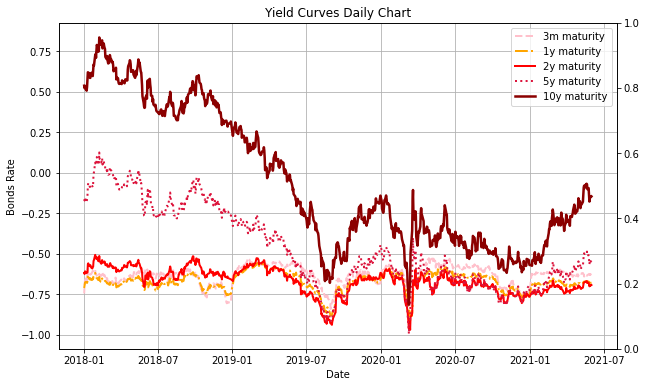

In [ ]:
#plot of yiels by date
fig, ax = plt.subplots(figsize=(10, 6))
axb = ax.twinx()
# Same as above
ax.set_xlabel('Date')
ax.set_ylabel('Bonds Rate')
ax.set_title('Yield Curves Daily Chart')
ax.grid(True)

ax.plot(yie0['date'], yie0['3m'], color='pink', label='3m maturity',linestyle = '--',linewidth = 2.0)
ax.plot(yie0['date'], yie0['1y'], color='orange', label='1y maturity',linestyle = '-.',linewidth = 2.0)
ax.plot(yie0['date'], yie0['2y'], color='red', label='2y maturity',linestyle = '-',linewidth = 2.0)
ax.plot(yie0['date'], yie0['5y'] , color='Crimson',linestyle = ':', label='5y maturity',linewidth = 2.0)
ax.plot(yie0['date'], yie0['10y'] , color='darkred',linestyle = '-', label='10y maturity',linewidth = 2.5)

#legend
lines, labels = ax.get_legend_handles_labels()
axb.legend(lines, labels, loc='upper right')

In [ ]:
import statsmodels.api as sm

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
x = df_final[['neg','pos','compound']]
y = df_final['10y']
#x = sm.add_constant(x)
model = sm.OLS(y,x).fit()
model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                    10y   R-squared (uncentered):                   0.001
Model:                            OLS   Adj. R-squared (uncentered):             -0.011
Method:                 Least Squares   F-statistic:                             0.1176
Date:                Sun, 04 Jul 2021   Prob (F-statistic):                       0.950
Time:                        09:20:02   Log-Likelihood:                          564.84
No. Observations:                 250   AIC:                                     -1124.
Df Residuals:                     247   BIC:                                     -1113.
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
neg            0.0262      0.059      0.448      0.655      -0.089       0.142
pos           -0.0194      0.048     -0.405      0.686      -0.114       0.075
compound       0.0016      0.003      0.475      0.635      -0.005       0.008
==============================================================================
Omnibus:                        3.965   Durbin-Watson:                   1.944
Prob(Omnibus):                  0.138   Jarque-Bera (JB):                4.428
Skew:                           0.126   Prob(JB):                        0.109
Kurtosis:                       3.602   Cond. No.                         43.4
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
x = df_final[['pos','neg','neu']]
y = df_final['10y']
#x = sm.add_constant(x)
model = sm.OLS(y,x).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                    10y   R-squared (uncentered):                   0.001
Model:                            OLS   Adj. R-squared (uncentered):             -0.011
Method:                 Least Squares   F-statistic:                             0.1048
Date:                Sun, 04 Jul 2021   Prob (F-statistic):                       0.957
Time:                        09:20:36   Log-Likelihood:                          564.82
No. Observations:                 250   AIC:                                     -1124.
Df Residuals:                     247   BIC:                                     -1113.
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
pos           -0.0191      0.050     -0.378      0.706      -0.119       0.080
neg           -0.0016      0.054     -0.030      0.976      -0.108       0.104
neu            0.0034      0.008      0.433      0.665      -0.012       0.019
==============================================================================
Omnibus:                        4.153   Durbin-Watson:                   1.939
Prob(Omnibus):                  0.125   Jarque-Bera (JB):                4.782
Skew:                           0.120   Prob(JB):                       0.0915
Kurtosis:                       3.633   Cond. No.                         28.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""